<a href="https://colab.research.google.com/github/sotetsuk/pgx/blob/nissymori%2Ffeat%2Fmctx_colab/colab/pgx_alpha_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# install libraries
!pip install -U jax[cuda11_cudnn82] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jaxlib==0.4.7+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install flax
!pip install optax
!pip install mctx
!pip install pgx
# for visualization
!pip install ipyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Training code**

We train AlphaZero agent in pgx environment with MCTS part depending on mctx.

In [2]:
import mctx
import jax 
from typing import Tuple

from jax import vmap
from jax import numpy as jnp
import pgx
from pgx.experimental.wrappers import auto_reset
from functools import partial
import optax
import flax 
import flax.linen as nn
from flax.training import train_state
import time

"""
This is the implementation of alphazero for 2 player zero-sum game with mctx for mcts and pgx for environment
"""


@flax.struct.dataclass
class TrainState(train_state.TrainState):
  acc: jnp.ndarray


def make_recurrent_fn(env: pgx.core.Env):
    """
    Make recurrent function for mctx policy.
    input: params(for value and policy calc), key(rng), actions(actions at leaf node), _state(leaf_state)
    rolls:
    - output value and policy at _state
    - get next state and reward by env.step() (In Muzero, this part is replaced by NN model, but we have fast simulator pgx, we do not need model based approach)
    """
    batch_step = jax.jit(vmap(env.step, in_axes=(0,0)))
    batch_obs = jax.jit(vmap(env.observe))
    def recurrent_fn(params: TrainState, key: jnp.ndarray, actions: jnp.ndarray, _state: pgx.State):
        train_state = params
        key, subkey = jax.random.split(key)
        state = batch_step(_state, actions)
        obs = batch_obs(state, state.current_player)
        value, pi_logits = train_state.apply_fn({"params": train_state.params}, obs.astype(float))
        reward=jax.vmap(_get)(state.reward, _state.current_player)  # rewardは行動したplayer視点
        value = jnp.where(state.terminated, 0.0, value.squeeze())
        recurrent_fn_output = mctx.RecurrentFnOutput(
        reward=reward,
        discount=-1 * jnp.ones(value.shape[0]),
        prior_logits=pi_logits,
        value=value)
        return recurrent_fn_output, state
    return recurrent_fn


def init(net: nn.Module, env: pgx.core.Env, key: jnp.ndarray, learning_rate=0.001) -> TrainState:  # initialize training state
    dummy_state = env.init(key)
    obs = env.observe(dummy_state, dummy_state.current_player)
    dummy_obs = obs.astype(float)

    params = net.init(key, dummy_obs)["params"]
    tx = optax.adam(learning_rate=learning_rate)
    return TrainState.create(apply_fn=net.apply, params=params, tx=tx, acc=jnp.zeros(1))


def update(x, vals, *indices):
  return x.at[indices].set(vals)


batch_update = jax.vmap(update)


@flax.struct.dataclass
class _SelfPlayState:
    """The state for the simulation while loop."""
    key: jnp.ndarray
    obs: jnp.ndarray
    mcts_policy: jnp.ndarray
    current_player: jnp.ndarray
    reward: jnp.ndarray
    terminated: jnp.ndarray



def self_play(env: pgx.core.Env ,key: jnp.ndarray, recurrent_fn, train_state: TrainState, num_iterations: int, num_simulations: int, batch_size: int) -> _SelfPlayState:
    """
    Self play.
    """
    auto_reset_step = auto_reset(env.step, env.init)
    def batched_single_step(tup, i) -> _SelfPlayState:
        """
        Batched single step using mcts policy
        """
        key, state = tup
        obs = vmap(env.observe)(state, state.current_player)  # (batch_size, obs_dim)
        value, pi_logits = train_state.apply_fn({"params": train_state.params}, obs.astype(float))  # value, policy
        key, subkey = jax.random.split(key)
        root = mctx.RootFnOutput(value=value.squeeze(), prior_logits=pi_logits, embedding=state)
        policy_output = mctx.gumbel_muzero_policy(
                params=train_state,
                rng_key=subkey,
                root=root,
                recurrent_fn=recurrent_fn,
                num_simulations=num_simulations,
                invalid_actions=~state.legal_action_mask
        ) # calc mcts policy
        mcts_policy = policy_output.action_weights  # (batch_size, num_actions)
        action = policy_output.action  # (batch_size, 1)
        next_state = vmap(auto_reset_step)(state, action)
        return (key, next_state), _SelfPlayState(
            key=key,
            obs=obs,
            mcts_policy=mcts_policy,
            current_player=state.current_player,
            reward=state.reward,
            terminated=state.terminated
        )
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, batch_size)
    state = vmap(env.init)(subkeys)
    _, selfplay_state = jax.lax.scan(batched_single_step, (key, state), jnp.arange(num_iterations))
    return selfplay_state


def _make_target_value_and_mask(reward: jnp.ndarray, terminated: jnp.ndarray) -> jnp.ndarray:
    """
    - For 2 player zero sum game, value target is the final reward(win/lose)
    - We need to make data with input observation and target final reward.
    - So we fill the reward vec the final reward of corresponding games.
    - Since we set num_iterations, the  trucation is likely, so we mask the data of unfinished match.
    """
    value = jnp.zeros(reward.shape, dtype=jnp.float32)  # (num_iterations, 2)
    mask = jnp.zeros(reward.shape[0], dtype=jnp.int8)  # (num_iterations)
    def fill_reward(sta, end, value):
        return jax.lax.fori_loop(sta, end, lambda i, val: val.at[i].set(reward[end]), value)
    def fill_mask(end, mask):
        return jax.lax.fori_loop(0, end, lambda i, val: val.at[i].set(1), mask)
    
    def loop_fn(i, tup):
        value, last_terminated_idx = tup
        new_terminated_idx = jax.lax.cond(terminated[i], lambda: i, lambda: last_terminated_idx)
        value = jax.lax.cond(terminated[i], lambda: fill_reward(last_terminated_idx, i, value), lambda: value)
        return (value, new_terminated_idx)
    value, last_terminated_idx = jax.lax.fori_loop(0, len(reward), loop_fn, (value, 0))
    mask = fill_mask(last_terminated_idx, mask)
    return value, mask


@flax.struct.dataclass
class _TrainData:
    """The state for the simulation while loop."""
    obs: jnp.ndarray
    mcts_policy: jnp.ndarray
    current_player: jnp.ndarray
    value: jnp.ndarray
    mask: jnp.ndarray


def _get_batch(data: _TrainData, idx: int):
    return (data.obs[idx], data.mcts_policy[idx], data.current_player[idx], data.value[idx], data.mask[idx])


def _get(x, idx):
    return x[idx]


def preprocess_data(selfplay_data: _SelfPlayState):
    obs = selfplay_data.obs  # (num_iterations, batch_size, obs_dim)
    mcts_policy = selfplay_data.mcts_policy  # (num_iterations, batch_size, num_actions)
    current_player = selfplay_data.current_player  # (num_iterations, batch_size)
    reward = selfplay_data.reward  # (num_iterations, batch_size, 2)
    terminated = selfplay_data.terminated  # (num_iterations, batch_size)
    value, mask = vmap(_make_target_value_and_mask, in_axes=(0))(reward.transpose(1, 0, 2), terminated.transpose(1, 0))  # (num_iterations, batch_size, 2), (num_itarations, batch_size)
    dataset = _TrainData(obs=obs, mcts_policy=mcts_policy, current_player=current_player, value=value.transpose(1, 0, 2), mask=mask.transpose(1, 0)) 
    return dataset


def train_step(train_state: TrainState, batch: Tuple[jnp.ndarray]) -> TrainState:
    """
    obs: (batch_size, obs_dim)
    mcts_policy: (batch_size, action_num)
    reward: (batch_size, 2) 
    current_player: (batch_size)
    """
    obs, mcts_policy, current_player, value, mask = batch
    def loss_fn(params) -> TrainState:
        v, p = train_state.apply_fn({"params": params}, obs)
        value_loss = optax.l2_loss(v.squeeze(), vmap(_get)(value, current_player)) * mask
        policy_loss = optax.softmax_cross_entropy(p.squeeze(), mcts_policy) * mask
        return (value_loss + policy_loss).mean()  # mask the loss without target value
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state


def train_epoch(train_state: TrainState, train_data: _TrainData, num_iterations: int) -> TrainState:
    """
    Update parameters using rollout Data
    """
    def loop_fn(i, train_state: TrainState):
        batch = _get_batch(train_data, i)
        return train_step(train_state, batch)
    train_state = jax.lax.fori_loop(0, num_iterations, loop_fn, train_state)
    return train_state


def train(net: nn.Module, env: pgx.core.Env, key: jnp.ndarray, epochs: int, num_iterations: int, num_simulations: int, batch_size: int):
    key, subkey = jax.random.split(key)
    train_state = init(net, env, subkey)  # initialize functions
    recurrent_fn = make_recurrent_fn(env)  # make recurrent function for mcts
    jitted_self_play = jax.jit(partial(self_play, env=env, recurrent_fn=recurrent_fn, num_iterations=num_iterations, num_simulations=num_simulations, batch_size=batch_size))
    jitted_preprocess_data = jax.jit(preprocess_data)
    jitted_train_epoch = jax.jit(partial(train_epoch, num_iterations=num_iterations))
    print("warmup_start")
    selfplay_data: _SelfPlayState = jitted_self_play(key=key, train_state=train_state) 
    train_data: _TrainData = jitted_preprocess_data(selfplay_data)
    train_state: TrainState = jitted_train_epoch(train_state=train_state, train_data=train_data)
    print("warmup end")
    sta=time.time()
        
    for i in range(epochs):
        selfplay_data: _SelfPlayState = jitted_self_play(key=key, train_state=train_state) 
        train_data: _TrainData = jitted_preprocess_data(selfplay_data)
        train_state: TrainState = jitted_train_epoch(train_state=train_state, train_data=train_data)  # update_param
        print(i)
    end=time.time()
    print(f"train end in {end-sta}")
    return train_state, recurrent_fn

/usr/local/lib/python3.9/dist-packages/pgx/_flax/struct.py:142: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/lib/python3.9/dist-packages/pgx/_flax/struct.py:142: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


**Evaluation code**

In this notebook, we evaluate the trained agent by the score against random agent.

In [30]:
import mctx
import jax 

from jax import vmap
from jax import numpy as jnp
import pgx
from functools import partial
from pgx._visualizer import Visualizer
from pgx.experimental.visualize import show_state_seq
    

def set_current_player(state, player):
    return state.replace(current_player=jnp.int8(player))

def act_randomly(rng: jax.random.KeyArray, state: pgx.State) -> jnp.ndarray:
    logits = jnp.log(state.legal_action_mask.astype(jnp.float16))
    return jax.random.categorical(rng, logits=logits, axis=1)

def mcts(
    state: pgx.State,
    train_state: TrainState,
    rng_key: jnp.ndarray,
    recurrent_fn,
    num_simulations: int
) -> jnp.ndarray:
    obs = state.observation  # the obs of current player
    rng_key, subkey = jax.random.split(rng_key)
    v, p = train_state.apply_fn({"params": train_state.params}, obs.astype(float))
    root = mctx.RootFnOutput(
        prior_logits=p.squeeze(),
        value=v.squeeze(),
        embedding=state
    )
    policy_output = mctx.gumbel_muzero_policy(
              params=train_state,
              rng_key=subkey,
              root=root,
              recurrent_fn=recurrent_fn,
              num_simulations=num_simulations,
              invalid_actions=~state.legal_action_mask
            )
    return policy_output.action


def evaluate(env: pgx.core.Env, train_state: TrainState, recurrent_fn, num_simulations: int, game: str,  batch_size=10, visualize_game=True) -> None:
    v = Visualizer()
    batched_init = jax.jit(jax.vmap(env.init))
    batched_step = jax.jit(jax.vmap(env.step, in_axes=(0,0)))
    batch_observe = jax.jit(jax.vmap(env.observe))
    jitted_mcts = jax.jit(partial(mcts, train_state=train_state, recurrent_fn=recurrent_fn, num_simulations=num_simulations))
    rng = jax.random.PRNGKey(0)
    rng, subkey = jax.random.split(rng)
    subkeys = jax.random.split(subkey, batch_size)

    s = batched_init(subkeys)
    rng, subkey = jax.random.split(rng)
    a = act_randomly(subkey, s)
    s = batched_step(s, a)
    rng = jax.random.PRNGKey(5)
    subkeys = jax.random.split(subkey, batch_size)
    state = batched_init(subkeys)
    state = jax.vmap(partial(set_current_player, player=0))(state)  # 初期agentのplayeridを0に固定
    i = 0
    reward = jnp.zeros((batch_size, 2))
    while not state.terminated.all():
        if i % 2 == 0:  # player_id0がmcts agent
            rng, subkey = jax.random.split(rng)
            action = jitted_mcts(state=state, rng_key=subkey)
        else:
            rng, subkey = jax.random.split(rng)
            action = act_randomly(subkey, state)
        state = batched_step(state, action)
        reward = reward + state.reward
        print(i)
        if visualize_game:
            v.save_svg(state, f"{game}{i:03d}.svg")
            show_state_seq(state)
        i += 1

    print(f"average return of mcts agent {jax.vmap(partial(_get, idx=0))(reward).sum()/batch_size} , average return of random agent {jax.vmap(partial(_get, idx=1))(reward).sum()/batch_size}")

In [28]:
class ValuePolicyNet(nn.Module):
  num_actions: int
  
  def setup(self):
    self.dense1 = nn.Dense(features=64)
    self.dense2 = nn.Dense(features=32)
    self.action_head = nn.Dense(features=self.num_actions)
    self.value_head = nn.Dense(features=1)

  @nn.compact
  def __call__(self, obs: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
    x = self.dense1(obs)
    x = nn.relu(x)
    x = self.dense2(x)
    x = nn.relu(x)
    v = self.value_head(x)
    p = self.action_head(x)
    return v, p

**Training**

Train AlphaZero agent in tic tac toe environment.

In [40]:
num_simulations=300  # the number of maximum length of simulations for one step mcts
num_iterations=40  # the length of rollout
epochs=3
batch_size=100

env = pgx.make("tic_tac_toe")
net = ValuePolicyNet(num_actions=env.action_shape[0])
key = jax.random.PRNGKey(0)


train_state, recurrent_fn = train(net, env, key, epochs, num_iterations, num_simulations, batch_size)  # train agent

warmup_start
warmup end
0
1
2
train end in 46.856420040130615


**Evaluation**

Evaluate the trained agent and visualize the paly. In the visualizatioin, "x" is the Alphazero agent's move and "o" is the random agent's

0


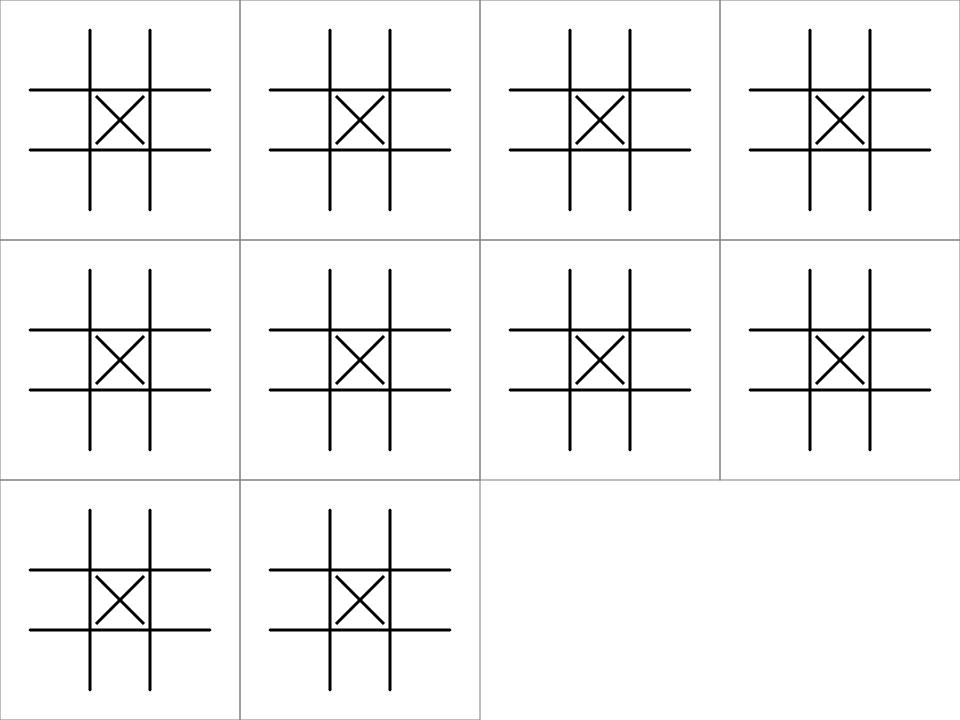

1


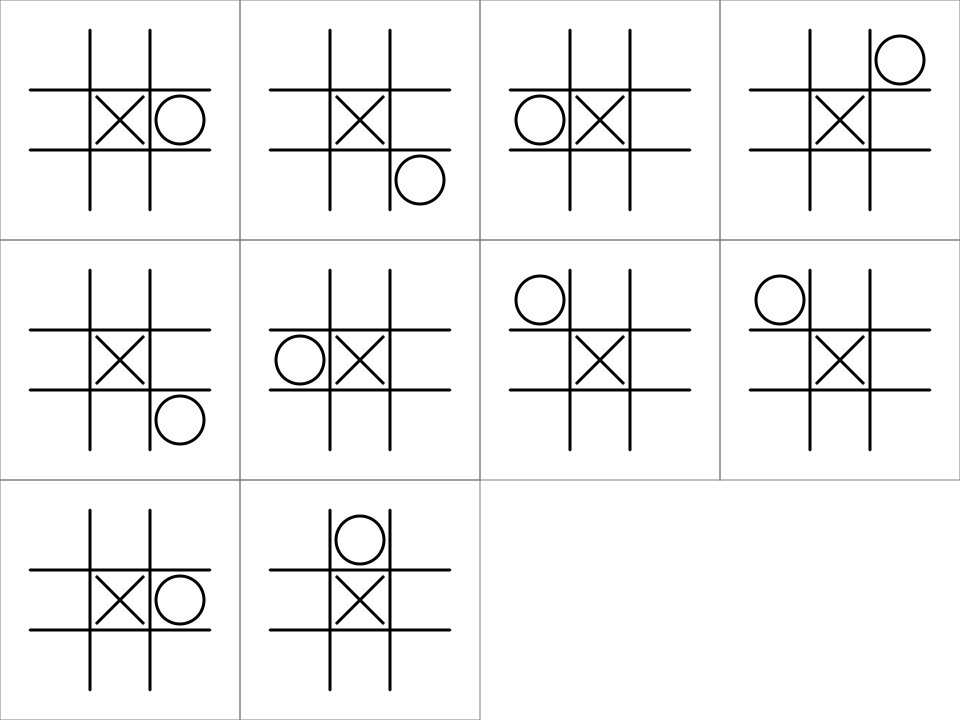

2


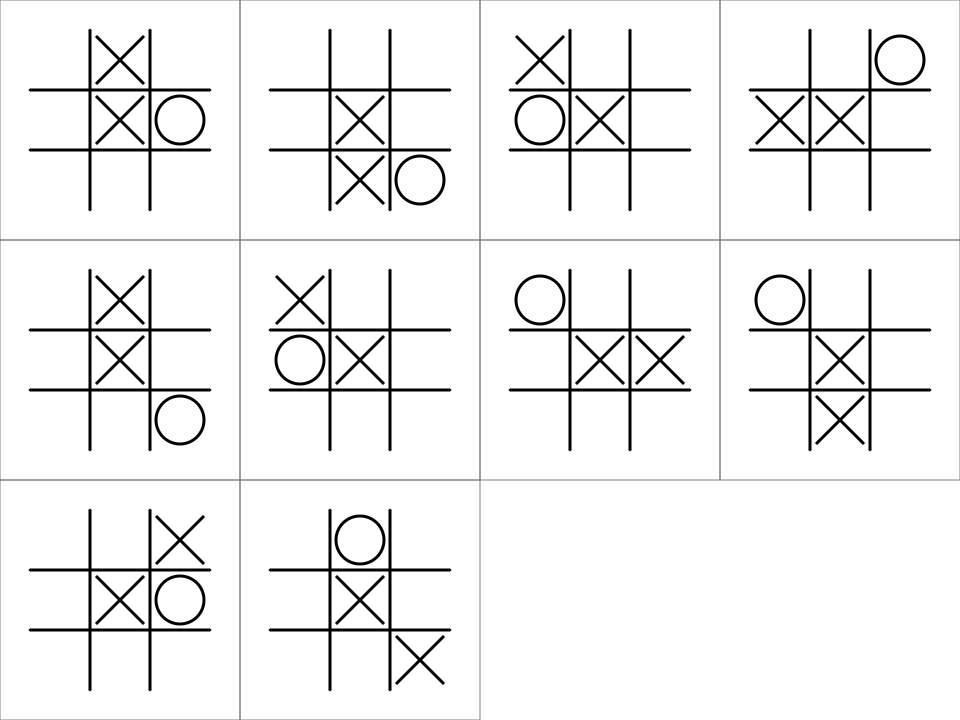

3


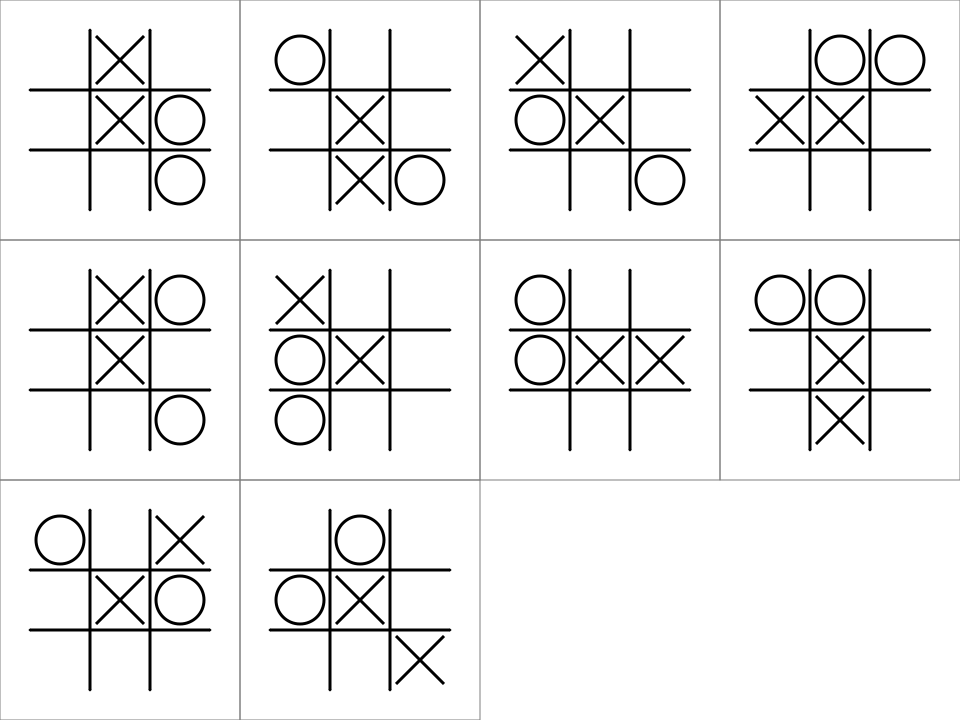

4


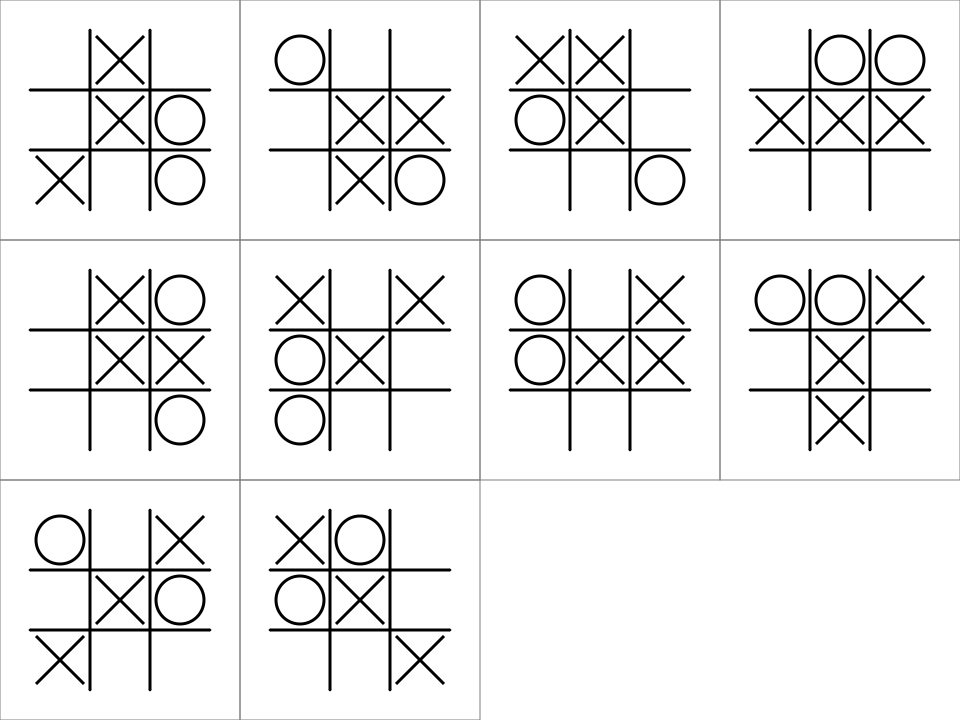

5


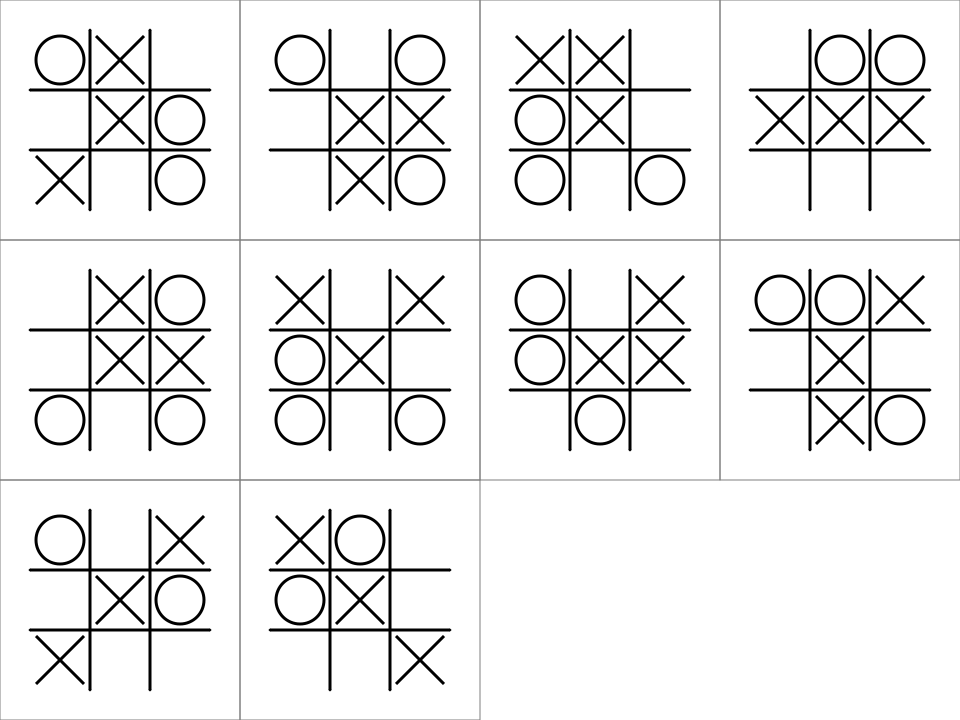

6


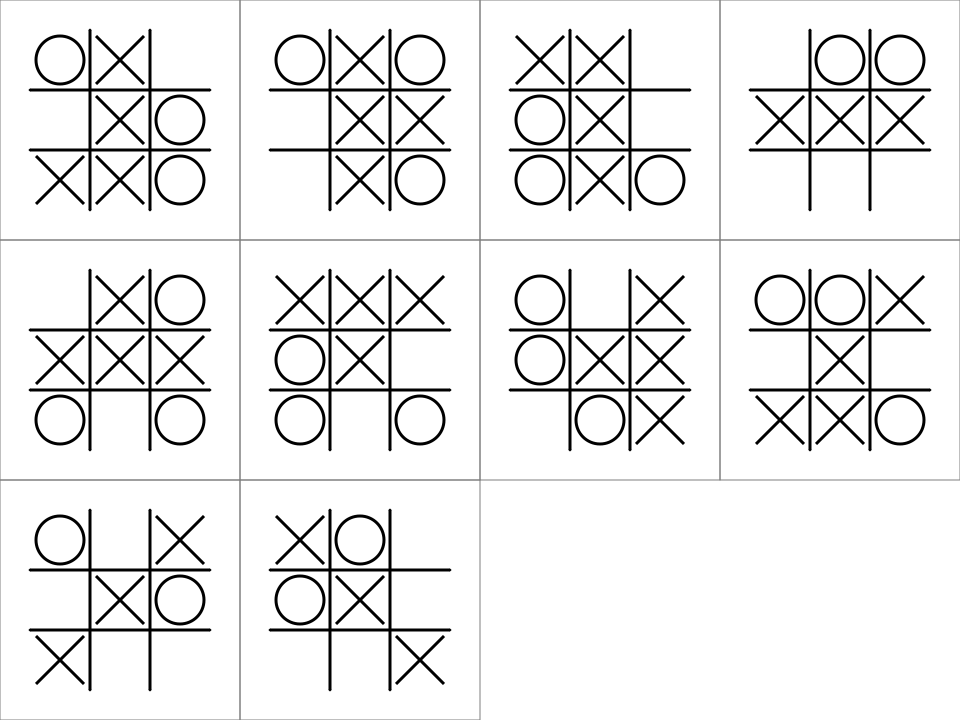

average return of mcts agent 1.0 , average return of random agent -1.0


In [41]:
evaluate(env, train_state, recurrent_fn, num_simulations, "tic_tac_toe")